In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

In [2]:
class TorchCNN(nn.Module):
    def __init__(self):
        """
        Initialize a 3-layer CNN.

        Args:
            in_channels: number of features of the input image
            hidden_channels: list of two numbers which are number of hidden features
            out_features: number of features in output layer
        """
        super(TorchCNN, self).__init__()

        self.layers = []

        # input layer
        self.convi = nn.Conv2d(1, 96, kernel_size=7, stride=2, padding = 1)
        self.relui = nn.ReLU()

        self.layers = [self.convi, self.relui]
        # hidden layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(96)
        self.conv1 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding = 1)
        self.relu1 = nn.ReLU()

        self.layers = self.layers + [self.pool1, self.norm1, self.conv1, self.relu1]

        # hidden layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(256)
        self.conv2 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding = 1)
        self.relu2 = nn.ReLU()

        self.layers = self.layers + [self.pool2, self.norm2, self.conv2, self.relu2]

        # hidden layer 3
        self.conv3 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding = 1)
        self.relu3 = nn.ReLU()

        self.layers = self.layers + [self.conv3, self.relu3]

        # hidden layer 4
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding = 1)
        self.relu4 = nn.ReLU()

        self.layers = self.layers + [self.conv4, self.relu4]

        # hidden layer 5
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.layers = self.layers + [self.pool5]

        # hidden layer 6
        self.flat1 = nn.Flatten()
        self.lino = nn.Linear(6*6*256, 10)
        self.softo = nn.Softmax(dim=1)

        self.layers = self.layers + [self.flat1, self.lino, self.softo]

#         # hidden layer 7
#         self.lin7 = nn.Linear(4096, 4096)

#         self.layers = self.layers + [self.lin7]
        
#         # output layer
#         self.lino = nn.Linear(4096, 10)
#         self.softo = nn.Softmax(dim=1)
        
#         self.layers = self.layers + [self.lino, self.softo]

    def forward(self, x):
        i=0
        for layer in self.layers:
            x = layer(x)
#             print(type(layer))
#             print(x.size())
#             if type(layer)==torch.nn.modules.conv.Conv2d:
#                 i+=1
#                 print(f'layer {i}, {type(layer)}')
        return x

In [3]:
model = TorchCNN()
model.layers

[Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 LocalResponseNorm(96, alpha=0.0001, beta=0.75, k=1.0),
 Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 LocalResponseNorm(256, alpha=0.0001, beta=0.75, k=1.0),
 Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=9216, out_features=10, bias=True),
 Softmax(dim=1)]

In [6]:
mnist_train = torch.load('../data/MNIST/processed/training.pt')
mnist_test = torch.load('../data/MNIST/processed/test.pt')


In [7]:
transform = transforms.Compose([transforms.Resize((224,224))])
train = []
for i in range(len(mnist_train[0])//100):
    train.append(transform(mnist_train[0][i*100:i*100+100]))
    
train = torch.stack(train).view(60000,224,224)

train_data = []
for data, label in zip(train, mnist_train[1]):
    train_data.append([data[None,:,:],label])
    
test = []
for i in range(len(mnist_test[0])//100):
    test.append(transform(mnist_test[0][i*100:i*100+100]))
    
test = torch.stack(test).view(10000,224,224)

test_data = []
for data, label in zip(test, mnist_test[1]):
    test_data.append([data[None,:,:],label])

In [34]:
# device = try_gpu()
# model.to('cpu')
# summary(model, (1,224, 224))

In [33]:
dummy = train_data[0][0].clone()
dummy = dummy[None,:,:,:]
k = dummy.float().clone()

features = []
for i in model.layers:
    k = i(k)
    if k.size()[2] < 224//16:
        break
    features.append(i)
    out_channels = k.size()[1]
print(f'number of layers = {len(features)}')
print(f'number of out channels = {out_channels}')
print()
print(*features, sep = "\n")

number of layers = 6
number of out channels = 256

Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
LocalResponseNorm(96, alpha=0.0001, beta=0.75, k=1.0)
Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
ReLU()


In [35]:
faster_rcnn_fe_extractor = nn.Sequential(*features)
faster_rcnn_fe_extractor

Sequential(
  (0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): LocalResponseNorm(96, alpha=0.0001, beta=0.75, k=1.0)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)

In [16]:
out_map = faster_rcnn_fe_extractor(dummy.float().clone())
print(out_map.size())

torch.Size([1, 256, 27, 27])


In [36]:
ratios = [0.5, 1, 2]
anchor_scales = [4, 8, 16]

anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)

print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [75]:
featuremapsize = out_map.size()[2]
subsample = 224/featuremapsize
ctr_y = subsample/2.
ctr_x = subsample/2.

for i in range(len(ratios)):
    for j in range(len(anchor_scales)):
        h = subsample * anchor_scales[j] * np.sqrt(ratios[i])
        w = subsample * anchor_scales[j] * np.sqrt(1./ ratios[i])

        index = i * len(anchor_scales) + j

        anchor_base[index, 0] =  - h / 2.
        anchor_base[index, 1] =  - w / 2.
        anchor_base[index, 2] =    h / 2.
        anchor_base[index, 3] =    w / 2.

In [76]:
anchor_base

array([[-11.732735, -23.46547 ,  11.732735,  23.46547 ],
       [-23.46547 , -46.93094 ,  23.46547 ,  46.93094 ],
       [-46.93094 , -93.86188 ,  46.93094 ,  93.86188 ],
       [-16.592592, -16.592592,  16.592592,  16.592592],
       [-33.185184, -33.185184,  33.185184,  33.185184],
       [-66.37037 , -66.37037 ,  66.37037 ,  66.37037 ],
       [-23.46547 , -11.732735,  23.46547 ,  11.732735],
       [-46.93094 , -23.46547 ,  46.93094 ,  23.46547 ],
       [-93.86188 , -46.93094 ,  93.86188 ,  46.93094 ]], dtype=float32)

(0.0, 224.0)

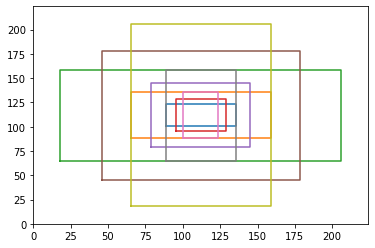

In [77]:
plt.figure()
ab = anchor_base + 112
for i in range(9):
    x = [ab[i,1],ab[i,3],ab[i,3],ab[i,1],ab[i,1]]
    y = [ab[i,0],ab[i,0],ab[i,2],ab[i,2],ab[i,0]]
    plt.plot(x,y)
plt.xlim([0,224])
plt.ylim([0,224])
# plt.plot([0,224,224,0,0],[224,224,0,0,224])

In [82]:
ctr_x = np.arange(subsample/2, (featuremapsize+.5) * subsample, subsample)
ctr_y = np.arange(subsample/2, (featuremapsize+.5) * subsample, subsample)

In [83]:
ctr_x = [int(x) for x in ctr_x]
ctr_y = [int(x) for x in ctr_y]

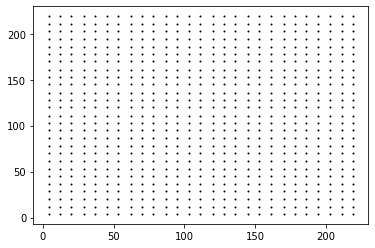

In [84]:
plt.figure()
for i in ctr_x:
    for j in ctr_y:
        plt.plot(i,j,'ok',markersize=1)

In [85]:
anchors = np.zeros((len(ctr_x)*len(ctr_y)*9,4))
index = 0
for x in ctr_x:
    for y in ctr_y:
        xy = np.array([y,x,y,x])
        anchors[index:index + 9,:] = anchor_base + xy
        index += 9

In [123]:
valid_anchors_poses = np.where(((anchors.T[0]>=0) & (anchors.T[1]>=0) &
         (anchors.T[2]<=224) & (anchors.T[3]<=224)),1,0)

In [124]:
valid_anchors = anchors[valid_anchors_poses>0,:].copy()

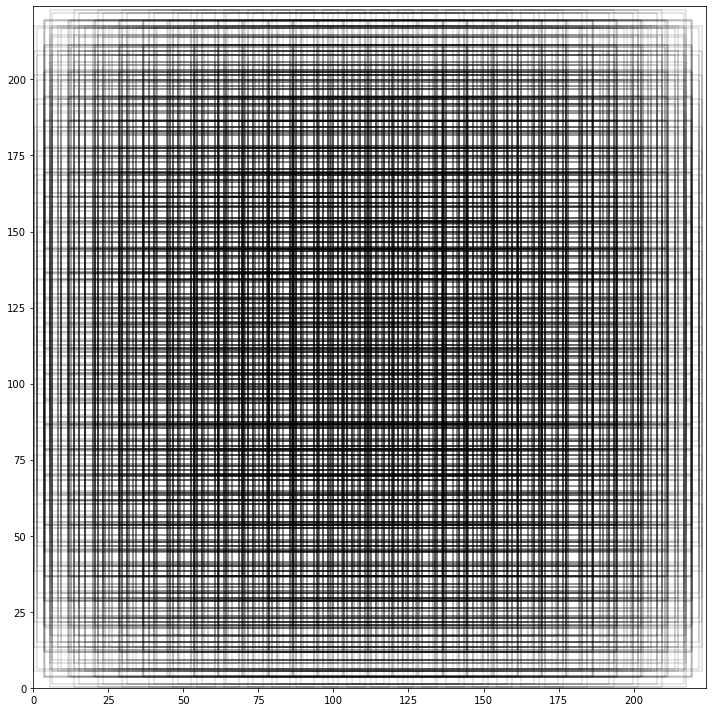

In [135]:
plt.figure(figsize=(10,10))
for ab in valid_anchors:
    x = [ab[1],ab[3],ab[3],ab[1],ab[1]]
    y = [ab[0],ab[0],ab[2],ab[2],ab[0]]
    plt.plot(x,y,'k',linewidth=.2)
plt.xlim([0,224])
plt.ylim([0,224])
plt.tight_layout()

[array([ 36,  28, 204, 196])]


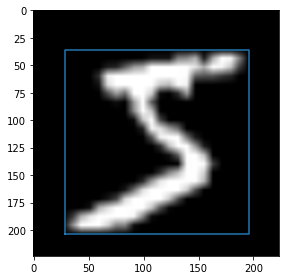

In [197]:
plt.figure()
plt.imshow(dummy.squeeze(),cmap='gray')
d = dummy.squeeze().squeeze()
for index, y in enumerate(d):
    if y.max()>0:
        y1 = index; break
        
for index, y in enumerate(reversed(d)):
    if y.max()>0:
        y2 = 224-index; break

for index, y in enumerate(d.T):
    if y.max()>0:
        x1 = index; break
        
for index, y in enumerate(reversed(d.T)):
    if y.max()>0:
        x2 = 224-index; break
        
dummy_anchor = [np.array([y1,x1,y2,x2])]
dummy_label = [5]
plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2])
plt.tight_layout()
print(dummy_anchor)

In [204]:
max_anchor_area = 0
ious = np.zeros((valid_anchors.shape[0], len(dummy_anchor)))
for indexa, xya in enumerate(valid_anchors):
    ya1, xa1, ya2, xa2 = xya
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    if anchor_area>max_anchor_area:
        max_anchor_area = anchor_area
    for indexb, xyb in enumerate(dummy_anchor):
        yb1, xb1, yb2, xb2 = xyb
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else: 
            iou = 0
        ious[indexa, indexb] = iou

In [205]:
max_anchor_area/box_area

0.6242950706367324

In [6]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

In [7]:
i1, l1 = next(iter(test_loader))

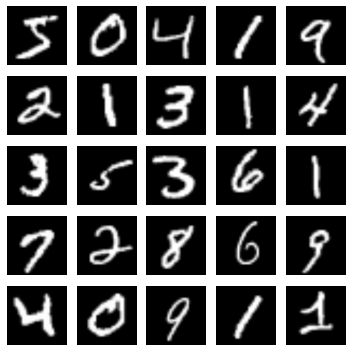

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, y = train_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(224, 224), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [27]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [10]:
# Try using gpu instead of cpu
device = try_gpu()
# device = 'cpu'

net = TorchCNN()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
summary(net, (1,224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 110, 110]           1,200
              ReLU-2         [-1, 24, 110, 110]               0
         MaxPool2d-3           [-1, 24, 55, 55]               0
 LocalResponseNorm-4           [-1, 24, 55, 55]               0
            Conv2d-5           [-1, 64, 27, 27]          38,464
              ReLU-6           [-1, 64, 27, 27]               0
         MaxPool2d-7           [-1, 64, 13, 13]               0
 LocalResponseNorm-8           [-1, 64, 13, 13]               0
            Conv2d-9           [-1, 96, 13, 13]          55,392
             ReLU-10           [-1, 96, 13, 13]               0
           Conv2d-11           [-1, 96, 13, 13]          83,040
             ReLU-12           [-1, 96, 13, 13]               0
           Conv2d-13           [-1, 64, 13, 13]          55,360
             ReLU-14           [-1, 64,

In [12]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for i, (X, y) in enumerate(data_loader):
        if i%10==0:
            print(i)
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        X = X.float()
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [14]:
epochs = 5

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):
        
        if i%50==0:
            print(f'batch {i}')

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.float()
#         y_batch = y_batch.type(torch.LongTensor) 
#         x_batch = x_batch.type(torch.LongTensor) 

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

batch 0
batch 50
batch 100
batch 150
batch 200
batch 250
batch 300
batch 350
batch 400
batch 450
batch 500
batch 550
batch 600
batch 650
batch 700
batch 750
batch 800
batch 850
batch 900
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
0
Epoch: 1
Accuracy of train set: 80%
Accuracy of test set: 80%

batch 0
batch 50
batch 100
batch 150
batch 200
batch 250
batch 300
batch 350
batch 400
batch 450
batch 500
batch 550
batch 600
batch 650
batch 700
batch 750
batch 800
batch 850
batch 900
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510

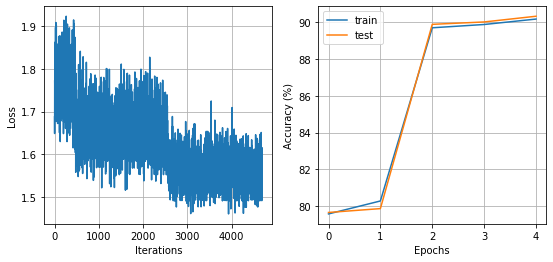

In [15]:
# Plot training curves
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()

In [41]:
test_batch = []
lab_batch = []
for i in range(10):
    t = test_data[400+i]
    test_batch.append(t[0])
    lab_batch.append(t[1])
test_batch = torch.stack(test_batch)
pred_batch = torch.argmax(net(test_batch.float()),dim=1)

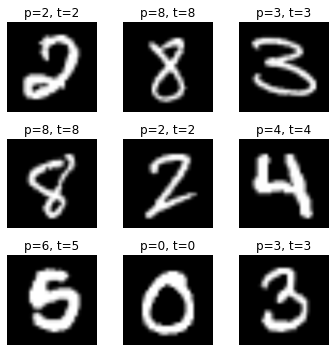

In [49]:
fig, axs = plt.subplots(3, 3, figsize=(5, 5))
for i in range(9):
    x, y = test_data[400+i]
    ax = axs[i // 3][i % 3]
    ax.imshow(x.view(224, 224), cmap='gray')
    ax.axis('off')
    ax.axis('off')
    ax.title.set_text(f'p={pred_batch[i]}, t={y.item()}')
plt.tight_layout()
plt.show()

In [50]:
train_accs,test_accs

([79.58166666666666,
  80.285,
  89.69333333333334,
  89.87166666666667,
  90.16666666666666],
 [79.66, 79.86999999999999, 89.88000000000001, 90.01, 90.32])